In [1]:
import torch
import os
import logging
import scanpy as sc
import random
import numpy as np
import scvi as scvi
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)


In [3]:
### Seed function to make more reproducible
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=42
set_seed(seed)

Global seed set to 42


In [4]:
### Load Mouse Data
adata = sc.read_h5ad(
    "../H5AD/mergedM.h5ad")


In [5]:
adata

AnnData object with n_obs × n_vars = 8398 × 34039
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cellName', 'line', 'chemistry', 'stage', 'sort'
    var: 'features'

In [6]:
adata.obs["orig.ident"].unique()

array(['Sample_32', 'Sample_33', 'Sample_34', 'Sample_C27_Shi',
       'Sample_WA09_Shiv'], dtype=object)

In [7]:
adata.obs["capture"] = adata.obs["orig.ident"]

In [8]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [9]:
### 3000 Features, span = .5
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="capture",
    span=.5
)

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["capture"],
    continuous_covariate_keys=["percent.mt", "nFeature_RNA", "nCount_RNA"]
)

In [11]:
model = scvi.model.SCVI(adata)

In [12]:
model.train(use_gpu=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|███████| 400/400 [18:35<00:00,  2.81s/it, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [18:35<00:00,  2.79s/it, loss=888, v_num=1]


In [13]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [14]:
model.save("../output/scVI/Mouse_Model")


In [15]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [16]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [17]:
model = scvi.model.SCVI.load("../output/scVI/Mouse_Model", adata = adata)

INFO     File ../output/scVI/Mouse_Model/model.pt already downloaded                                               


In [18]:
# 50.  Seed = 0
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 30, random_state=seed)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
# min_dist = .6, spread = .6
sc.tl.umap(adata, min_dist = .3, random_state=seed)

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


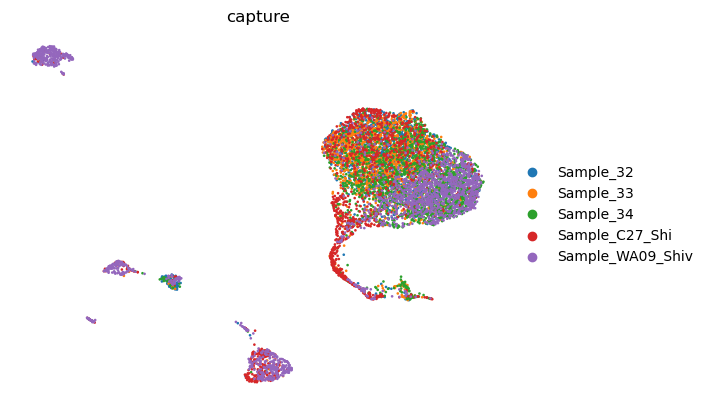

In [20]:
#1
sc.pl.umap(
    adata,
    color=["capture"],
    frameon=False
)

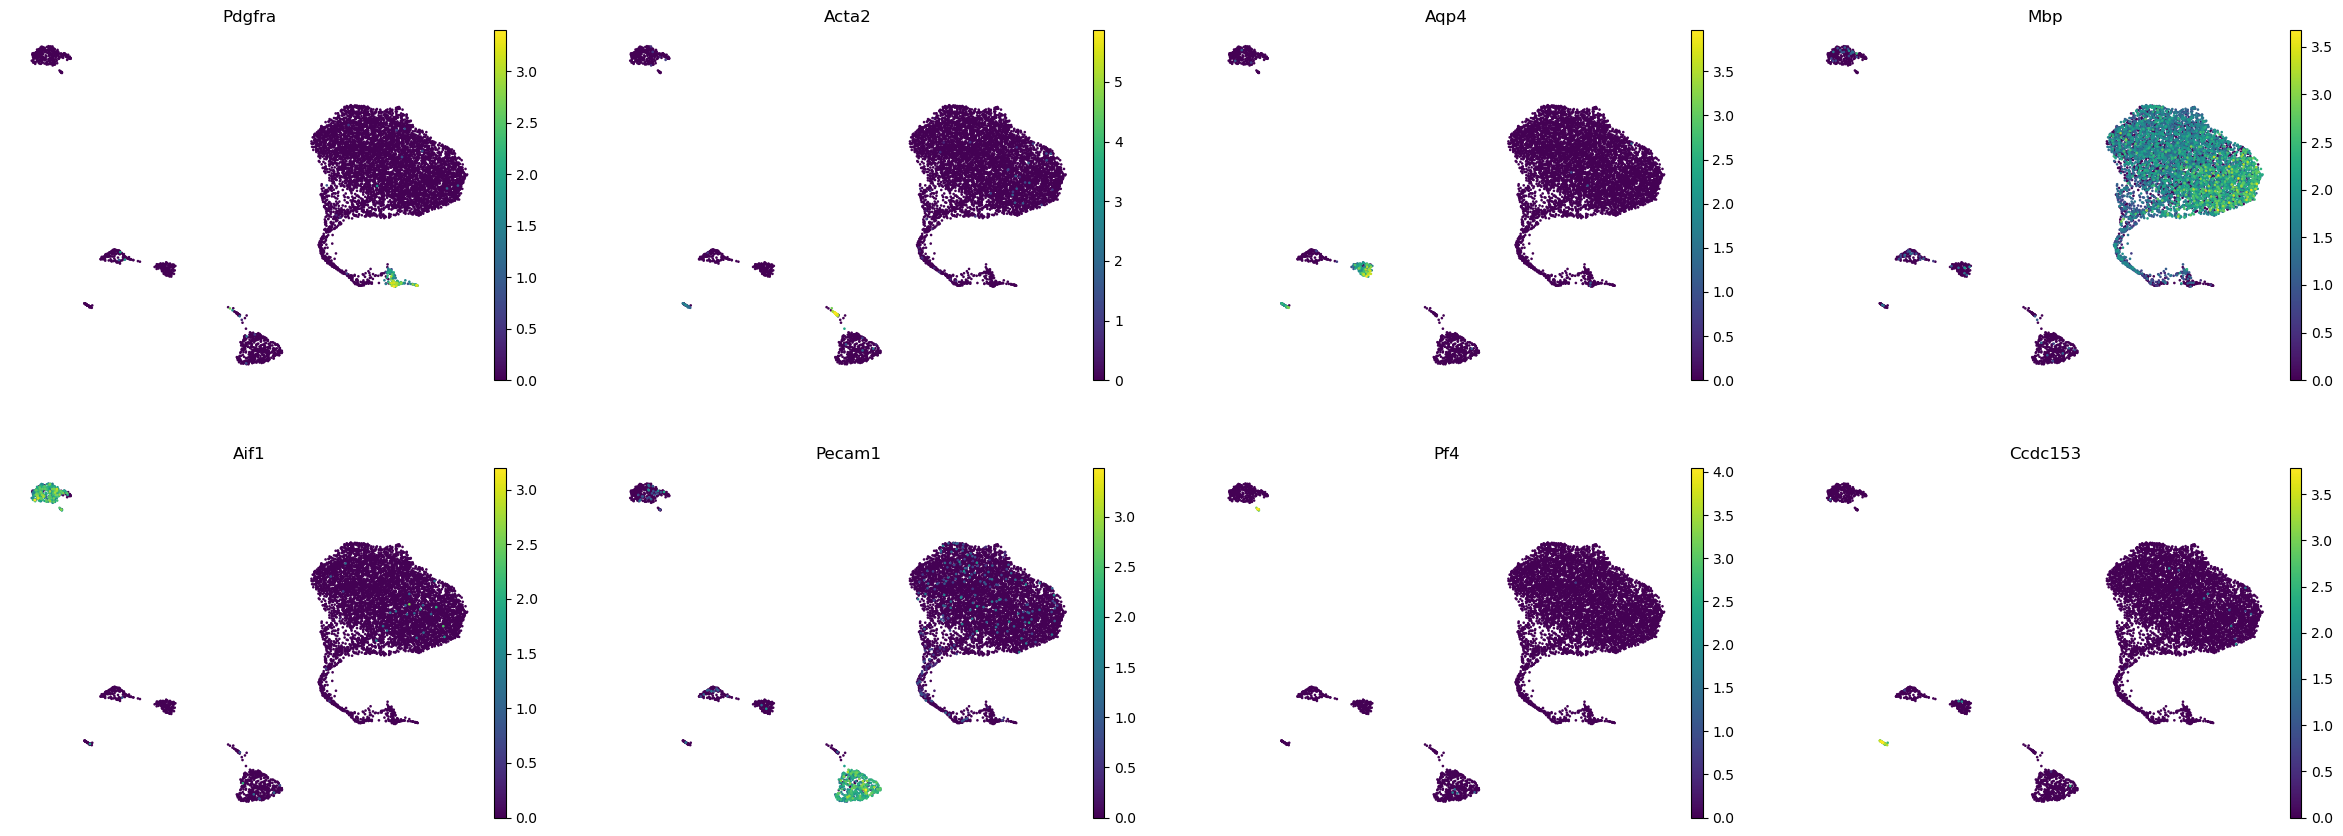

In [21]:
#1
sc.pl.umap(
    adata,
    color=["Pdgfra", "Acta2", "Aqp4", "Mbp", "Aif1", "Pecam1", "Pf4", "Ccdc153"],
    frameon=False
)

In [28]:
# 1.3
sc.tl.leiden(adata, key_added="leiden_scVI", resolution= 1.3)



/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


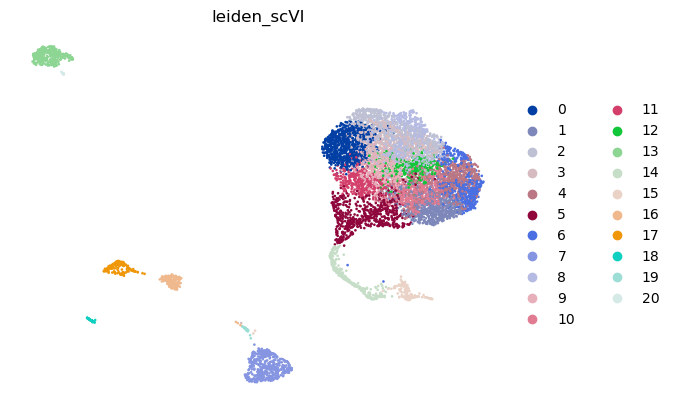

In [29]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
    
)

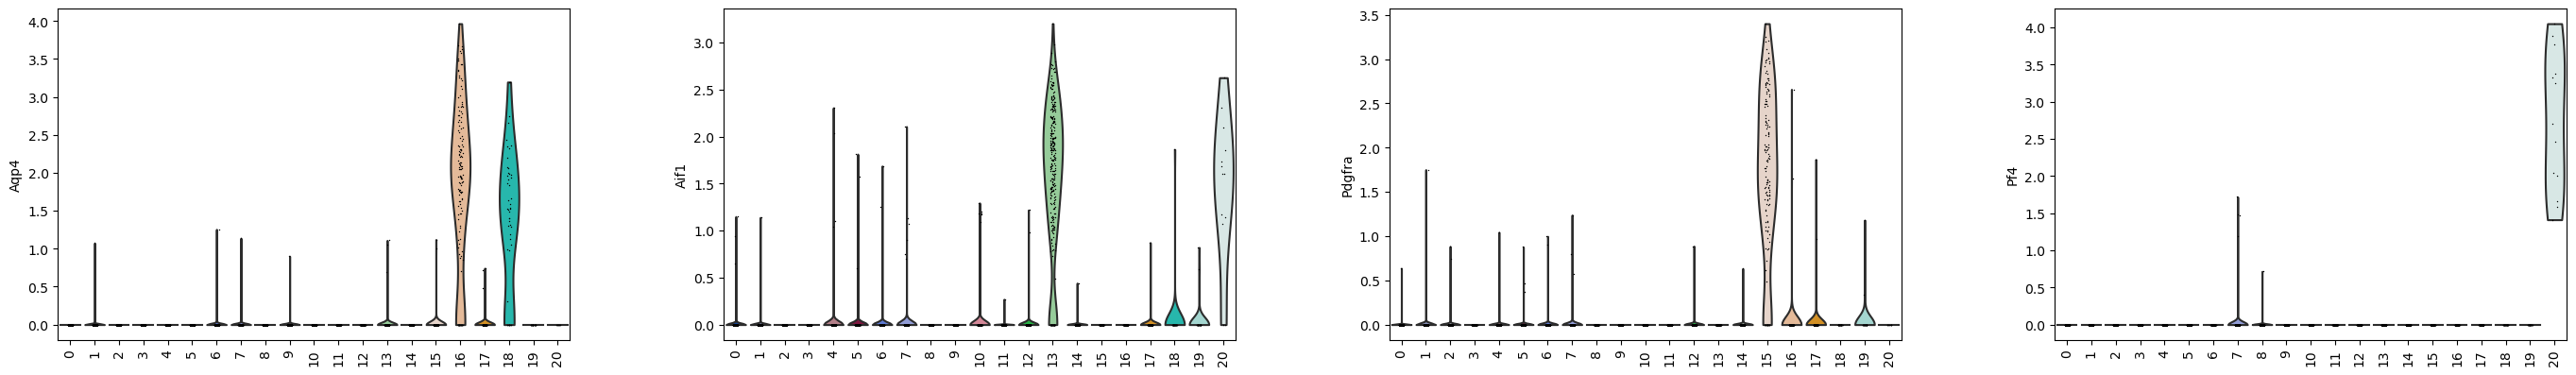

In [30]:
sc.pl.violin(adata, keys = ["Aqp4", "Aif1", "Pdgfra", "Pf4"], groupby="leiden_scVI", rotation = 90)

In [31]:
### Save adata and write out umap embeddings and leiden clusters

In [32]:
adata.write("../output/scVI/Mouse_scVI.h5ad")

In [33]:
umapEmbeddings = adata.obsm["X_umap"]

In [34]:
np.savetxt("../output/scVI/Mouse_umapEmbeddings.csv", umapEmbeddings, delimiter=",")

In [35]:
leiden_clusters = adata.obs["leiden_scVI"]

In [36]:
adata.obs["leiden_scVI"].to_csv('../output/scVI/Mouse_leidenClusters.csv')


In [37]:
sc.__version__

'1.9.3'

In [38]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.13.1
logging==0.5.1.2
scanpy==1.9.3
numpy==1.23.5
scvi==0.20.3
